# Predictive Coding for Image Classification (MNIST)

This notebook implements a minimal predictive coding model with three hidden layers and lateral connections for image classification on the MNIST dataset.

In [53]:
# !pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading

In [3]:
transform = transforms.ToTensor()

data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(data)

images, _ = next(iter(loader))

mean = images.mean().item()
std = images.std().item()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000)

print(f"Mean: {mean}, Std: {std}")

Mean: 0.1376800686120987, Std: 0.3125477433204651


## Predictive Coding Network Definition

In [4]:
class PredictiveCodingNet(nn.Module):
    def __init__(self, input_dim, h1_dim, h2_dim, h3_dim, output_dim, lateral_strength=0.1):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(h1_dim, input_dim) * 0.1)
        self.W2 = nn.Parameter(torch.randn(h2_dim, h1_dim) * 0.1)
        self.W3 = nn.Parameter(torch.randn(h3_dim, h2_dim) * 0.1)
        self.W4 = nn.Parameter(torch.randn(output_dim, h3_dim) * 0.1)
        self.L1 = nn.Parameter(torch.eye(h1_dim) * lateral_strength)
        self.L2 = nn.Parameter(torch.eye(h2_dim) * lateral_strength)
        self.L3 = nn.Parameter(torch.eye(h3_dim) * lateral_strength)
        self.b1 = nn.Parameter(torch.zeros(h1_dim))
        self.b2 = nn.Parameter(torch.zeros(h2_dim))
        self.b3 = nn.Parameter(torch.zeros(h3_dim))
        self.b4 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, num_infer_steps=20, lr_state=0.2):
        batch_size = x.size(0)
        s1 = torch.zeros(batch_size, self.W1.shape[0], device=x.device)
        s2 = torch.zeros(batch_size, self.W2.shape[0], device=x.device)
        s3 = torch.zeros(batch_size, self.W3.shape[0], device=x.device)
        s4 = torch.zeros(batch_size, self.W4.shape[0], device=x.device)
        for _ in range(num_infer_steps):
            pred_s1 = F.linear(x, self.W1, self.b1) + torch.matmul(s1, self.L1)
            pred_s2 = F.linear(s1, self.W2, self.b2) + torch.matmul(s2, self.L2)
            pred_s3 = F.linear(s2, self.W3, self.b3) + torch.matmul(s3, self.L3)
            pred_s4 = F.linear(s3, self.W4, self.b4)
            e1 = s1 - pred_s1
            e2 = s2 - pred_s2
            e3 = s3 - pred_s3
            e4 = s4 - pred_s4
            s1 = F.relu(s1 - lr_state * e1)
            s2 = F.relu(s2 - lr_state * e2)
            s3 = F.relu(s3 - lr_state * e3)
            s4 = F.softmax(s4 - lr_state * e4, dim=1)
        return s1, s2, s3, s4

    def predict(self, x):
        _, _, _, s4= self.forward(x)
        return s4

## Training and Evaluation Functions

In [5]:
def train(model, train_loader, test_loader=None, num_epochs=5, lr_weight=1e-3, num_infer_steps=20, lr_state=0.2):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            s1, s2, s3, s4 = model.forward(images, num_infer_steps=num_infer_steps, lr_state=lr_state)
            target = F.one_hot(labels, num_classes=10).float()
            output_error = s4 - target
            loss = (output_error ** 2).mean()
            total_loss += loss.item() * images.size(0)
            model.W4.data -= lr_weight * torch.matmul(output_error.t(), s3) / images.size(0)
            model.b4.data -= lr_weight * output_error.mean(dim=0)
            hidden_error = torch.matmul(output_error, model.W4)
            model.W3.data -= lr_weight * torch.matmul(hidden_error.t(), s2) / images.size(0)
            model.b3.data -= lr_weight * hidden_error.mean(dim=0)
            model.L3.data -= lr_weight * torch.matmul(s3.t(), hidden_error) / images.size(0)
            hidden_error = torch.matmul(hidden_error, model.W3)
            model.W2.data -= lr_weight * torch.matmul(hidden_error.t(), s1) / images.size(0)
            model.b2.data -= lr_weight * hidden_error.mean(dim=0)
            model.L2.data -= lr_weight * torch.matmul(s2.t(), hidden_error) / images.size(0)
            hidden_error = torch.matmul(hidden_error, model.W2)
            model.W1.data -= lr_weight * torch.matmul(hidden_error.t(), images) / images.size(0)
            model.b1.data -= lr_weight * hidden_error.mean(dim=0)
            model.L1.data -= lr_weight * torch.matmul(s1.t(), hidden_error) / images.size(0)
            pred = s4.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
        avg_loss = total_loss / total
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        if test_loader is not None:
            val_loss, val_acc = test(model, test_loader, num_infer_steps=num_infer_steps, lr_state=lr_state, verbose=False)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [6]:
def test(model, test_loader, num_infer_steps=20, lr_state=0.2, verbose=True):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            s4 = model.predict(images)
            pred = s4.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            target = F.one_hot(labels, num_classes=10).float()
            output_error = s4 - target
            loss = (output_error ** 2).mean()
            total_loss += loss.item() * images.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    if verbose:
        print(f"Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

# Summary of the model

In [7]:
input_dim = 28 * 28
h1_dim = 128
h2_dim = 64
h3_dim = 32
output_dim = 10
model = PredictiveCodingNet(input_dim, h1_dim, h2_dim, h3_dim, output_dim).to(device)
summary(model, input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
PredictiveCodingNet                      [1, 128]                  132,650
Total params: 132,650
Trainable params: 132,650
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.53
Estimated Total Size (MB): 0.53

## Run Training and Evaluation

Epoch 1/10, Training Loss: 0.0830, Training Accuracy: 0.3347, Val Loss: 0.0617, Val Accuracy: 0.5699
Epoch 2/10, Training Loss: 0.0390, Training Accuracy: 0.7350, Val Loss: 0.0270, Val Accuracy: 0.8188
Epoch 3/10, Training Loss: 0.0243, Training Accuracy: 0.8358, Val Loss: 0.0215, Val Accuracy: 0.8517
Epoch 4/10, Training Loss: 0.0207, Training Accuracy: 0.8606, Val Loss: 0.0189, Val Accuracy: 0.8722
Epoch 5/10, Training Loss: 0.0188, Training Accuracy: 0.8734, Val Loss: 0.0176, Val Accuracy: 0.8791
Epoch 6/10, Training Loss: 0.0176, Training Accuracy: 0.8817, Val Loss: 0.0167, Val Accuracy: 0.8855
Epoch 7/10, Training Loss: 0.0168, Training Accuracy: 0.8866, Val Loss: 0.0156, Val Accuracy: 0.8951
Epoch 8/10, Training Loss: 0.0162, Training Accuracy: 0.8909, Val Loss: 0.0155, Val Accuracy: 0.8953
Epoch 9/10, Training Loss: 0.0157, Training Accuracy: 0.8947, Val Loss: 0.0151, Val Accuracy: 0.8957
Epoch 10/10, Training Loss: 0.0155, Training Accuracy: 0.8960, Val Loss: 0.0149, Val Accura

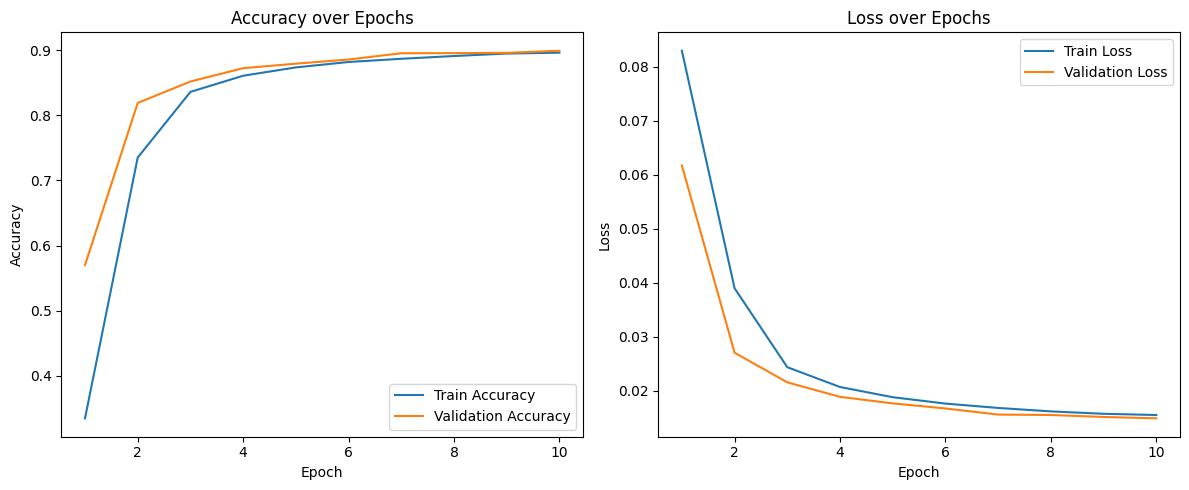

In [8]:
num_epochs = 10
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, test_loader=test_loader, num_epochs=num_epochs, lr_weight=1e-3, num_infer_steps=20, lr_state=0.2)

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()